---
title: "딥러닝 소개 - 사용자 정의 손실 함수"
date: 2020-07-19T17:30:47+09:00
tags:
  - "Tensorflow"
  - "Deep Learning"
  - "Python"
  - "딥러닝"
categories:
  - "Tensorflow"
  - "Deep Learning"
  - "Python"
  - "딥러닝"
menu: 
  kaggle:
    name: 사용자 정의 손실 함수
---


## 공지 
- 본 Tutorial은 교재 `핸즈온 머신러닝 2판`를 활용하여 본 강사로부터 국비교육 강의를 듣는 사람들에게 자료 제공을 목적으로 제작하였습니다.

- 강사의 주관적인 판단으로 압축해서 자료를 정리하였기 때문에, 자세하게 공부를 하고 싶은 분은 반드시 교재를 구매하실 것을 권해드립니다. 
> 책 정말 좋습니다! 꼭 구매하세요!

<!-- ![](/img/python_edu/07_deeplearning/handsOn_logo.jpg#center) -->

## 개요
- 인경 신경망은(`Artificial Neural Network`)을 촉발시킨 근원임
  + 뇌에 있는 생물학적 뉴런의 네트워크에서 영감을 받은 머신러닝 모델
- 활용예제
  + 수백만개의 이미지 분류
  + 수백만개의 비디어 추천
  + 매우 복잡한 문제를 풀 때 유용한 머신러닝 모델
- Keras API
  + 케라스는 신경망 구축, 훈련, 평가, 실행을 목적으로 설계된 API이자, 프레임워크


### (1) 주요 환경 설정
- 주요 환경 설정은 아래와 같이 정의합니다. 

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow import keras

# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 불필요한 경고를 무시합니다 (사이파이 이슈 #5998 참조)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## I. 사용자 정의 손실 함수를 활용한 예제
- 통계의 알고리즘은 매우 다양하며 또한 복잡하다. 
- 프레임워크는 개발을 편리하게 해주는데 도움을 주는 것이지, 모든 알고리즘이 다 있는 것은 아니다. 
- 예) 회귀 모형의 손실 함수 적용 시,
  + 평균 제곱 오차(MSE), 평균 절대값 오차(MAE), 후버 손실 (교재 10장 참조)
  + 그런데, 후버 손실 함수가 없다면 어떻게 될까?
- 공식 `케라스 API`에서는 지원하지 않는다. 
  + 다행히, `keras.losses.Huber` 클래스에서 지원한다. 
  + 그런데, 미세 조정이 필요하다면 또는 없을 경우에는 알고리즘을 통해 직접 구현해야 한다. 


### (1) 데이터 로드
- 위 내용의 예시를 구하기 위해 데이터를 불러온다.

In [2]:
# 캘리포니아 데이터셋 관련 패키지
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 데이터 로드 및 데이터 훈련/테스트 데이터 분리
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

# 데이터 스케일
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

- 교재 471 페이지에 제시된 후버손실 함수를 정의합니다. 

In [3]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

### (2) 후버손실 시각화
- 후버 손실의 대한 개념도를 위한 시각화를 작성한다. 
- 후버 손실은 임계값보다 작을 때의 이차함수이며, 오차가 임계값보다 클 때는 선형 함수가 된다. 
- 장점은 평균제곱 오차보다 이상치에 덜 민감하고, 단점은 평균 절대값 오차보다 더 빠르고 정확하게 수렴한다. 

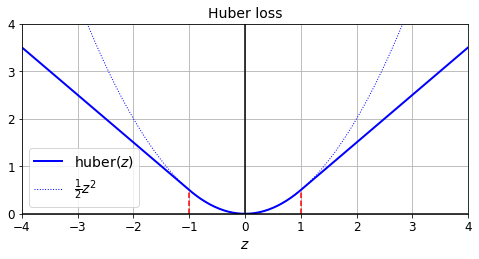

In [4]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

- 전체 손실의 평균이 아니라 샘플마다 하나의 손실을 담은 텐서를 반환하는 것이 좋다. 이렇게 해야 필요할 때 케라스가 클래스 가중치나 샘플 가중치 적용이 가능
- 이제 이 손실을 사용해 케라스 모델의 컴파일 메서드를 호출하고 모델을 훈련할 수 있다. 

### (3) 모형 정의 및 사용자 정의 함수 적용
- 간단한 모형을 정의한다. 

In [5]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

- 여기에서 사용자 정의 함수가 어떻게 적용되는지 살펴본다. 

In [6]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

- 보통 `loss=`에는 "mae" 또는 "mse"를 입력하기만 해도 된다. 
- 그러나 여기에서는 함수의 명이 직접적으로 들어가는 것을 확인할 수 있따. 

### (4) 모형 학습
- 이제 모형을 학습한다. 

In [7]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.5774 - mae: 0.9335 - val_loss: 0.2102 - val_mae: 0.5019
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2153 - mae: 0.5123 - val_loss: 0.2085 - val_mae: 0.4933


### (5) 모형 테스트
- 학습된 모형을 테스트에 적용한다.

In [8]:
example_batch = X_test_scaled[:10]
example_result = model.predict(example_batch)
example_result

array([[0.0832686],
       [1.8661963],
       [2.9778893],
       [2.6951659],
       [2.7565494],
       [1.908314 ],
       [2.6455936],
       [1.7626797],
       [3.0349858],
       [4.096979 ]], dtype=float32)

### (6) 모형 저장
- 생성된 모형을 아래와 같이 저장한다. 

In [9]:
model.save("my_model_with_huber.h5")

## II. 사용자 정의 함수 관련 모델
- 지난 시간에 이어서, 진행한다. 
- 모형을 저장하는 것은 매우 중요하다. 
  + ML/DL 모형 시, 많은 학습 시간이 필요하기 때문에 저장하는 것이 중요하다. 
  + 그런데, 사용자 정의 함수를 `loss`에 입력한 것에 유의해야 한다. 
 

### (1) 모형 불러오기
- 저장 시에는 별도 설정이 필요하지 않지만, 다음과 같이 코드 작성해야 한다. 
```python
keras.models.load_model("my_model.h5", custom_objects={"name_of_function": name_of_function})
```
- 사용자 정의 객체를 포함함 모델을 불러올 때는 이름과 객체를 매핑 시켜야 한다.

In [10]:
model = keras.models.load_model("my_model_with_huber.h5", 
                                custom_objects={"huber_fn":huber_fn})

### (2) Currying Function 적용
- 처음 정의한 사용자 정의 함수는 -1과 1사이의 오차는 작은 것으로 간주함
- 그런데, 만약 다른 기준 필요 시 어떻게 해야할까?
  + 예를 들어, `threshold`를 기준을 각 사용자마다 다르게 변화를 주고 싶다면 어떻게 해야할까?
  + 교재는 다음과 같이 정리하였다.

In [11]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

- 위 함수는 [currying function](https://www.geeksforgeeks.org/currying-function-in-python/)으로 불리운다. 
- `threshold default`는 1.0으로 되어 있는데, 이를 수정할 수가 있다.  

In [16]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.save("my_model_with_huber_threshold_2.h5")

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2150 - mae: 0.4804 - val_loss: 0.2210 - val_mae: 0.4754
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2132 - mae: 0.4781 - val_loss: 0.2011 - val_mae: 0.4604


- 그런데, 위와 같이 모형을 생성 후 저장을 할 때에는 `threshold=2.0`은 저장되지 않는다. 
- 따라서 불러올 때는 다음과 같이 모형을 불러와야 한다. 

In [17]:
model = keras.models.load_model("my_model_with_huber_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

In [18]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2093 - mean_absolute_error: 0.4729 - val_loss: 0.2385 - val_mean_absolute_error: 0.4819
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2071 - mean_absolute_error: 0.4703 - val_loss: 0.2538 - val_mean_absolute_error: 0.4770


- 그런데, `custom_objects={}`와 같이 작성하는 것이 번거롭다면, `class`를 직접 작성하는 것도 도움이 된다. 
- 이 내용은 교재를 참고하였으면 좋겠다. 

### (3) 사용자 정의 활성화함수 적용
- `huber`라는 사용자 정의 함수를 적용했듯이, 활성화 함수도 같이 적용이 가능하다. 
  + 물론, 이러한 다음 정의하는 사용자 정의 함수도 이미 `Keras API`에 정의가 되어 있기는 하다. 
- 세션을 클리어 한뒤, 다시 실험 재현을 위해 다음 코드를 작성한다. 

In [19]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [20]:
def my_softplus(z): # tf.nn.softplus(z) 값을 반환합니다
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # tf.nn.relu(weights) 값을 반환합니다
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

- 사용자 정의 함수를 활용하여 `layer`를 만들 수 있다. 

In [24]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)


In [31]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

- 사용자 정의 활성화 함수를 적용하여 학습 시킨 뒤, 모형을 저장한다. 

In [36]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

model.save("my_model_with_many_custom_parts.h5")

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 2.1606 - mae: 0.9112 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 1.0011 - mae: 0.5538 - val_loss: inf - val_mae: inf


- 저장된 모형을 다시 불러온다. 
- 이 때 불러온 모형은 `huber_fn` 손실 함수를 적용할 때와 비슷하게 `custom_objects`를 사용한다.  

In [37]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

### (4) 그 외
- 핸즈온 머신러닝에서는 위와 유사한 방식으로 사용자 정의 함수를 활용하여 `custom metrics`, `custom layers`, `custom model` 등을 정의할 수 있는데, 이 부분은 교재와 소스코드를 참고하시기를 바란다. 

## III. 결론
- 본 포스트에서 확인할 수 있었던 것은 사용자 정의 손실 함수가 필요한 것은 결국 보다 정밀하게 수식을 적용하기 위함이다. 
- `Class` 사용해야 하는 필요성은 모형 `save & load`와 연관성이 있는데, 수정된 `threshold`와 같이 임의의 값을 넣어 적용한 경우에는 별도로 `Class`화 하여 처리하는 것이 필요했다. 
- 또한, 손실함수, 활성화함수 뿐만 아니라, 거의 모든 분야에서 사용자 정의 모델은 만들수 있음을 교재에서는 말해주고 있다. 